In [190]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import make_scorer


def my_loss_fn(ytruetest, ytruetrain, ypredtest, ypredtrain):
    loss = np.array([[0,1,2],[1,0,1],[2,1,0]])
    days = len(ytruetest)
    losstrain = np.zeros(days)
    losstest = np.zeros(days)
    acctrain = np.zeros(days)
    acctest = np.zeros(days)
    acctrain1 = np.zeros(days)
    acctest1 = np.zeros(days)
    
    for i in range(days):
        conftrain = confusion_matrix(ytruetrain[i], ypredtrain[i])
        acctrain[i] = (conftrain[0,0] + conftrain[2,2])/np.sum(conftrain[0] + conftrain[2])
        acctrain1[i] = (conftrain[0,0] + conftrain[2,2])/np.sum(
            conftrain[0,0] + conftrain[0,2] + conftrain[2,0] + conftrain[2,2])
        losstrain[i] = np.sum(conftrain * loss)
        
        conftest = confusion_matrix(ytruetest[i], ypredtest[i])
        acctest[i] = ((conftest[0,0] + conftest[2,2])/
                      np.sum(conftest[0] + conftest[2]))
        acctest1[i] = (conftest[0,0] + conftest[2,2])/np.sum(
            conftest[0,0] + conftest[0,2] + conftest[2,0] + conftest[2,2])
        losstest[i] = np.sum(conftest * loss)
    
    ind = [('Day ' + str(i+1))for i in range(days)]
    col = ['Loss Train','Loss Test','Accuracy Train 1',
           'Accuracy Train 2','Accuracy Test 1',
           'Accuracy Test 2']
    retv = zip(col,(losstrain, losstest, acctrain, acctrain1, acctest, acctest1))
    return pd.DataFrame(dict(retv),index=ind)

# Loading in Data

In [266]:
DF = pd.read_csv('ESH2019_final.csv',
                 index_col = 0,
                 dtype={'Time':str})

D:\Programs\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [267]:
DF.head()

,Date,msecs,Time,Bid Price,Bid Size,Ask Price,Ask Size,Mid,dM,M_10ma,...,OI,OI_a1,OI_a2,OI_a3,OI_a4,OI_a5,OI_5ma,OI_10ma,OI_20ma,OI Ratio
0,01/02/2019,28800000.0,07:59:59.757,2467.50,9.0,2467.75,36.0,2467.625,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.600000
1,01/02/2019,28800500.0,08:00:00.305,2467.25,36.0,2467.50,19.0,2467.375,-0.25,NaN,...,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.309091
2,01/02/2019,28801000.0,08:00:00.826,2467.25,42.0,2467.50,3.0,2467.375,0.00,NaN,...,22.0,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866667
3,01/02/2019,28801500.0,08:00:01.349,2467.25,29.0,2467.50,30.0,2467.375,0.00,NaN,...,-40.0,22.0,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.016949
4,01/02/2019,28802000.0,08:00:01.761,2467.25,42.0,2467.50,22.0,2467.375,0.00,NaN,...,21.0,-40.0,22.0,-19.0,NaN,NaN,NaN,NaN,NaN,0.312500


In [95]:
DF.loc[:,'Time'] = DF.loc[:,'Time'].replace(np.nan,'',regex=True)

##### extract out trading days (non-Sunday) #####
day_p = np.zeros(DF.shape[0])
dates = np.unique(DF['Date'].values)
wknd = [day for day in dates if datetime.strptime(day,'%m/%d/%Y').weekday()>=5]
for idx, day in enumerate(wknd):
    day_p += DF['Date'].values == day
    
DF = DF[day_p == 0]
#################################################

DF.head()

# Exploration

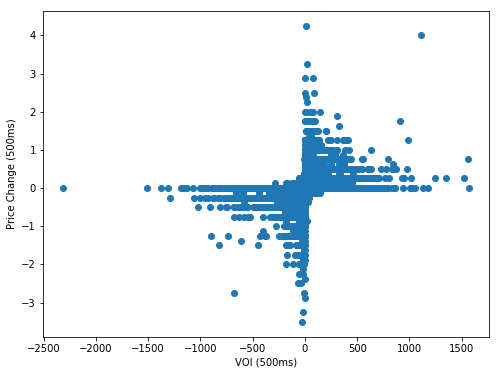

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(DF['OI'],DF['dM'])
plt.xlabel("VOI (500ms)")
plt.ylabel("Price Change (500ms)")
plt.show()

In [5]:
DF[['OI','dM']].corr()

,OI,dM
OI,1.000000,0.401592
dM,0.401592,1.000000


# SVM

## Extracting days

In [6]:
dates = np.unique(DF['Date'].values)
wkdys = [day for day in dates if datetime.strptime(day,'%m/%d/%Y').weekday()<5]
train_dys = wkdys[:7]

In [7]:
train_dys

['01/02/2019',
 '01/03/2019',
 '01/04/2019',
 '01/07/2019',
 '01/08/2019',
 '01/09/2019',
 '01/10/2019']

In [10]:
x_labs = ['OI_a1', 'OI_a2', 'OI_a3', 'OI_a4', 'OI_a5'] # covars
y_labs = ['signal','signal2','signal3','signal4','signal5','signal6']

# list of data frames for the first 7 business days
tdf = [DF.loc[DF['Date'] == d,x_labs+y_labs].dropna() for d in train_dys]

In [9]:
def my_confusion_matrix(mat):
    # input is whatever is returned by sklearn's
    # confusion matrix
    cols = ['Buy (p)','Hold (p)','Sell (p)']
    ind = ['Buy (t)','Hold (t)','Sell (t)']
    return pd.DataFrame(mat, columns=cols,index=ind)

## SVM Model 1

### Testing the code

In [141]:
dates = np.unique(DF['Date'].values)
df_list = [DF.loc[DF['Date']==d,x_labs+['signal6']].dropna() for d in dates]

In [150]:
train_list = df_list[:4] # first 4 days
x_labs = ['OI_a1','OI_a2','OI_a3','OI_a4','OI_a5']

# signal6

# What we want
#   training predictions
#   test predictions
#   signal columns

In [189]:
conf_mats = []
ypred_tr  = [] # store training predictions
ypred_te  = [] # store test predictions
times     = [] # fitting times


for idx, dft in tqdm(enumerate(train_list[:-1])):
    print("---------- Day",idx+1,'----------\n')
    mat_vec = []  # store the confusion matrices
    
    svmfit = svm.LinearSVC(C=10**-2,class_weight = 'balanced')
    
    today = dft                # train on today
    tom   = train_list[idx+1]  # test on tomorrow
    
    #####
    start = time.time()
    print("Training...")
    svmfit.fit(today[x_labs].values,today['signal6'].values)
    end = time.time()
    t = np.int64(end-start)
    print("Training complete...", t)
    times.append(t)
    #####
    
    y_tr   = today['signal6'].values
    y_te   = tom['signal6'].values
    
    print("Predicting on training...")
    yhat_r = svmfit.predict(today[x_labs])
    
    print("Predicting on test...")
    yhat_e = svmfit.predict(tom[x_labs])
    
    ypred_tr.append(yhat_r)
    ypred_te.append(yhat_e)
    
    tr_mat = confusion_matrix(y_tr, yhat_r,labels=[1,0,-1])
    te_mat = confusion_matrix(y_te, yhat_e,labels=[1,0,-1])
    mat_vec = [my_confusion_matrix(tr_mat),my_confusion_matrix(tr_mat)]
    
    conf_mats.append(mat_vec)


0it [00:00, ?it/s]

---------- Day 1 ----------

Training...
Training complete... 12
Predicting on training...
Predicting on test...



1it [00:12, 12.44s/it]

---------- Day 2 ----------

Training...
Training complete... 12
Predicting on training...
Predicting on test...



2it [00:24, 12.43s/it]

---------- Day 3 ----------

Training...
Training complete... 11
Predicting on training...
Predicting on test...



3it [00:37, 12.36s/it]


In [181]:
ytruetest = [train['signal6'].values for train in train_list[1:]]
ytruetrain= [train['signal6'].values for train in train_list[:-1]]

In [182]:
my_loss_fn(ytruetest,ytruetrain,ypred_te,ypred_tr)

,Loss Train,Loss Test,Accuracy Train 1,Accuracy Train 2,Accuracy Test 1,Accuracy Test 2
Day 1,30672.0,31693.0,0.555573,0.772740,0.553760,0.765241
Day 2,31700.0,31674.0,0.555877,0.765182,0.594732,0.776941
Day 3,30310.0,29896.0,0.561655,0.788181,0.593237,0.802550


## Cross Validation

In [260]:
from sklearn.model_selection import cross_validate

def trading_loss(ytrue,ypred):
    conftrain = confusion_matrix(ytrue, ypred)
    loss = np.array([[0,1,2],[1,0,1],[2,1,0]])
    return np.sum(conftrain * loss)


trade_scorer=make_scorer(trading_loss,greater_is_better=False)

### Extracting the train/test indexes

In [281]:
def my_train_test_idx(DF,xlabs=xlabs,ylabs=['signal6'],return_df=False,n_days=4):
    '''
    input your data frame and which x's you want to use
        as a list into xlabs
        
    return_df to return new data frame for CV
    return value is list of 2-tuples of train & test
        index iterables
        - pass directly into the cv parameter of cross_validate
    '''
    df = DF[['Date']+xlabs+ylabs].dropna()
    
    #list of lengths of each day's data
    lengths = []
    for d in np.unique(DF['Date'].values)[:n_days]:
        lengths.append(df[df['Date']==d].shape[0])
    
    # where each day starts/ends
    bounds = np.cumsum(lengths)
    
    # list of 2-tuples of train & test indexes
    train_test_idx=[]
    prev=0
    for idx,val in enumerate(bounds[:-1]):
        train_id = range(prev,val)
        test_id = range(val,b[idx+1])
        prev = val
        train_test_idx.append((train_id,test_id))
    
    if return_df:
        return(train_test_idx,df)
    return (train_test_idx)

In [282]:
xlabs = ['OI_a1','OI_a2','OI_a3','OI_a4','OI_a5','OI Ratio']
ylab = ['signal6']

idxs,df = my_train_test_idx(DF,xlabs,return_df=True)

In [284]:
# what C values do I want
#sv = svm.LinearSVM(dual=False,C=1,class_weight = 'balanced')
sv = svm.LinearSVC(dual=False,class_weight='balanced')
tmp = cross_validate(sv,X = df[xlabs].values,
                     y = df['signal6'].values,
                     scoring=trade_scorer,
                     cv=idxs,
                    return_train_score=True)

In [ ]:
for c in np.logspace(10**-4,1,5):
    sv = svm.LinearSVC(C=c,dual=False,class_weight='balanced')
    